# Investigating and Correcting Bias in NLP Models

Welcome to the Investigating and correcting bias in word vectors for NLP models, an assignment of CSCM21 (Abuses Bias and Blessings of Data) delivered by Dr Matt Roach. Here you will gain experience in using investigating and correcting bias in algorithms. Specifically in this lab we will look at a method of converting unstructured text into numerical representations (vectors) that also embed semantic understanding into the numerical feature space. This is commonly known as word2vec, and used in many computational Natural Language Processing (NLP) tasks, such as: text prediction, document topic classification, language translation and many more.

State of the art performance in NLP research has recently seen a transition of focus from rule-based or word-frequency probabilistic models to probabilistic models based on word-vector representations within the last decade. These types of models have made great strides in our ability to learn semantic relationships between words allowing for much richer modelling of natural language that has been possible with rule-based and word-frequency based approaches. One such example is the 'GloVe' word embeddings by Pennington <i> et al</i> [1], in this lab we will be using a word embedding model trained with the GloVe method.
    
Moreover, the world has seen a growth in large pre-trained models based on this new breed of NLP algorithms, and as such, there is a real danger that developer could adopt and embed these models in software products and services without being aware of the possible unintended consequences. You will be taking a look at how you might detect bias in word vector models and a method we could use to de-bias the model post-training presented by Bolukbasi <i>et al.</i> in titled <i>"Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"</i> [2]


[1] J. Pennington, R. Socher, and C. D. Manning, “GloVe: Global vectors for word representation,” in EMNLP 2014  Conference on Empirical Methods in Natural Language Processing, Proceedings of the Conference, 2014 [Link to Paper](https://nlp.stanford.edu/projects/glove/).


[2] T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama, and A. Kalai, “Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings,” Jul. 2016.[Link to Paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

[3] This workbook is an based on one created by Andrew Ng and reuses some material with thanks.

## Learning Objectives:

- Investigate word similarity a pre-trained word embedding model.
- Use word embeddings to solve word analogy problems.
- Design counter factual word analogies to detect bias in the word embedding model.
- Modify the word embedding model to reduce its gender bias.
- Critically reflect on the effectiveness and limitations of the de-bais methods used.

Run the following cell to load the packages you will need.

In [3]:
import sys
import os
import tensorflow as tf
from platform import python_version 

#------------- Load in some helpful packages we will use for the lab -------------------------

import numpy as np
from w2v_utils import * # included in the lab download file.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import copy


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 
print ("TensorFlow version: " + tf.__version__) # print the tensorflow version


Python version: 3.7.12
Python path: /usr/bin/python3
Working Directory: /content
TensorFlow version: 2.8.0


# 1. Vectorised Word Embeddings Models

A reminder from work covered in the lecture, word vectors are generated using supervised training in the form of an auto-encoder.

<center><img src="images/w2v.png" width="800px"/></center>

<caption><center> <b>Figure</b> 1:  Word2Vec is a 3 layer architecture, with an input layer size equal to the size of the vocabulary, hidden layer of size of the embedding vector (typically 200-300 in this lab we will use a model based on 50) and output size again equal to the vocab size.</center></caption>
  
The input to the network is a 1-hot vector (a vector which all values are 0 except the value corresponding to the input word). This essentially acts as a mask on the embedding space, so that only the input word outputs nonzero activations from the embedding space through to the output layer. The output layer then predicts expected word based on the input words. The training objective function is a simple measure of the prediction performance. For the workbook we will work on the word embeddings - that are the outputs of the hidden layer from above, for each word - post training.


## 1.1 Load the Word Embedding Vectors. 

In this section, we will use 50-dimensional GloVe vectors to represent words.  We will not need to train the model or infact generate the vectors for each word this part has already been done. 

In the following line of code we will load a file "glove.6B.50d.txt" and stores the contents in python variables `word_to_vec_map` and `words`.

In [4]:
words, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

Above you have loaded:
- `words`: set of words in the vocabulary.
- `word_to_vec_map`: a python dictionary that contains the word GloVe vector representation for each word.
 - note the index to retrieve a single word vector from `word_to_vec_map` is the word itself i.e. to get the vector for mother you can use the syntax `word_to_vec_map[mother]`.

Lets take a look at the loaded sets of words and word vectors in the cell below investigate words that are in the models and take a look at their word vectors. 

**You need to:**
- find out the number of words in our vocabulary, i.e. print the number of elements (words) in `words`. Hint use `len`.
- print the vector for the word "farther".
- investigate the word vector for a small number (approx. 5) of different words. 
 - Note print each example to the note book (don't overwrite, in order to present examples of your exploration).

In [5]:
### START CODE ###
num_words = len(words)
print(f'Number of words : {num_words}')
### END CODE ###

### START CODE ###
word = 'father'
print(f'Word embedding for the word father :\n  {word_to_vec_map[word]}\n')

words = ['doctor', 'tree', 'chemical', 'laptop', 'vehicle']
for word in words:
    print(f'{word}:\n {word_to_vec_map[word]}\n')
### END CODE ###

Number of words : 400000
Word embedding for the word father :
  [ 0.095496   0.70418   -0.40777   -0.80844    1.256      0.77071
 -1.0695     0.76847   -0.87813   -0.0080954  0.43884    1.0476
 -0.45071   -0.58931    0.83246   -0.038442  -0.73533    0.26389
  0.12617    0.57623   -0.23866    1.0922    -0.3367     0.081537
  0.84798   -2.4795    -0.40351   -0.84087    0.12034    0.29074
  1.9711    -0.50886   -0.45977   -0.13617    0.55613    0.22924
 -0.18947    0.43544    0.65151    0.043537  -0.1162     0.72196
 -0.66163   -0.17272    0.27367   -0.28169   -0.82025   -1.5089
  0.052787  -0.035579 ]

doctor:
 [ 0.66999   0.11698  -0.46322  -0.90012   0.5656    0.4898   -0.26031
  0.71268   0.62338   0.02785   0.68012   0.76745  -0.020365  0.52097
  0.80622  -0.20537  -0.88263   0.25707  -0.18035   0.80969  -0.24148
  1.1617    0.30834   0.65495   0.32863  -2.2849   -0.69219  -0.71241
 -0.50242  -0.076541  1.8624   -0.20323  -0.64749  -0.51617   0.50273
  0.78918   0.62624   0.37496   1

## 1.2  Visualising  Word Vectors

In this next section we will investigate the semantic meaning embedded in the word vectors. To do this you will presenting example word vectors. The vector element values will be visuliased using a colour from the jet color map range illustrated below from blue (low) to red (high), the maximum and minimum range of the color maps is normalised to the max and min vector componet value contined in all the vectors in `word_to_vec_map`.

<center><img src="images/jet_colour.png" style="width:400px"></center>
    
<center><caption> <b>Figure 2:</b> Jet Colour Range (Left/Blue Least, Right/Red Most)</caption></center>

**Your tasks is to:**
    
- Calucate the maximum and minimum vector component values - buy running the cell below


In [6]:
def viz_vectors(word_to_vec_map, vec_max, vec_min, word_1, word_2, word_3):
    """
    This funtion accepts three words and returns a figure handle for a plot.
    
    Inputs:
    word_to_vec_map - data dictionary conatin a map form work 'keys' to vectors
    vec_max  - a float containg maximum vector element value in dictionary
    vec_min - a float containg lowest vector element value in dictionary
    word_1 - string containing a word 
    word_2 - string containing a word
    word_3 - string containing a word
    
    Outputs:
    fig - a handle to a plot
    """

    wordvec_1 = word_to_vec_map[word_1]
    wordvec_2 = word_to_vec_map[word_2]
    wordvec_3 = word_to_vec_map[word_3]
    view_wordvec_1 = np.reshape(wordvec_1, (1, 50))
    view_wordvec_2 = np.reshape(wordvec_2, (1, 50))
    view_wordvec_3 = np.reshape(wordvec_3, (1, 50))

    fig = plt.figure(figsize = (15,2))

    ax1 = fig.add_subplot(311)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_title(word_1)
    ax1.imshow(view_wordvec_1, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)

    ax2 = fig.add_subplot(312)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.imshow(view_wordvec_2, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)
    ax2.set_title(word_2)
    
    ax3 = fig.add_subplot(313)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.set_title(word_3)
    ax3.imshow(view_wordvec_3, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)
    
    return(fig)

def vec_max_min(word_to_vec_map):
    vec_max = 0
    vec_min = 0

    for key in word_to_vec_map:
        if np.amax(word_to_vec_map[key]) > vec_max:
            vec_max = np.amax(word_to_vec_map[key])
        if np.amin(word_to_vec_map[key]) < vec_min:
            vec_min = np.amin(word_to_vec_map[key])

    return(vec_max,vec_min)

vec_max, vec_min = vec_max_min(word_to_vec_map)

print("the minimun vector componet value in the whole vocablray is: ", vec_min)
print("the maximum vector componet value in the whole vocablray is: ", vec_max)


the minimun vector componet value in the whole vocablray is:  -5.4593
the maximum vector componet value in the whole vocablray is:  5.3101


**Expected Output**:

<table>
    <tr>
        <td>
            minimun vector componet value
        </td>
        <td>
         -5.4593
        </td>
    </tr>
        <tr>
        <td>
            maximum vector componet value
        </td>
        <td>
         5.3101
        </td>
    </tr>
</table>



**In the follwing cell your tasks is to:**
    
-  Visualise an addtinal three sets of three vectors where two vectors are similar semantically and have similar patterns in the vector visulisation and a third that is related but different in both semantic meaning and a difference can been seen in the vector visulisation, you can do this by calling the function `viz_vectors`.

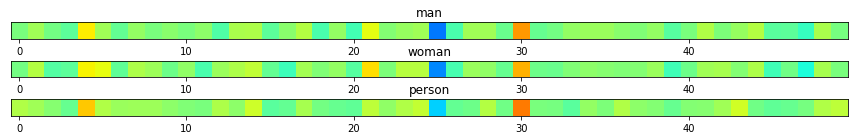

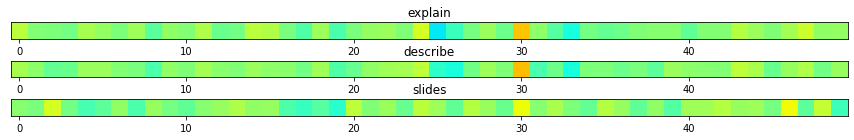

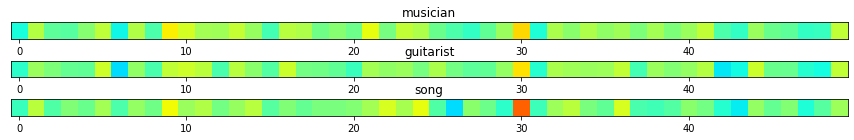

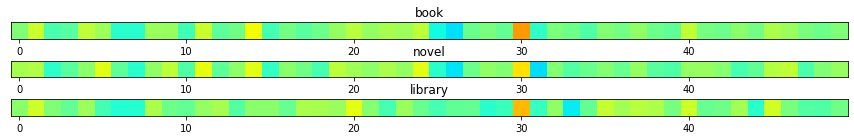

In [7]:

fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'man', 'woman', 'person')
plt.show()

##### START CODE #######

#Step 1: vizulise first set of three words
fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'explain', 'describe','slides')
plt.show()

#Step 1: vizulise first set of three words
fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'musician', 'guitarist','song')
plt.show()

#Step 1: vizulise first set of three words
fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'book', 'novel','library')
plt.show()

##### END CODE #########

## 1.3 Viewing Word Clusters in the Vector Space

In this section you will view the vectors plotted in the feature space, since our feature space is 50 dimensions we will use a dimension reduction technique to be able to plot the vectors in a 2-dimensional space. This technique compresses the 50 dimension into 2 whilst trying to retain the most significant information. Although is inevitable this technique looses discriminatory information we can still visualise semantic relationships in the vector space, as illustrated in the figure below.

<center><img src="images/Country_Capital_Vectors.png" width="500px"/></center>

<caption><center> <b>Figure 3:</b> Visulisation of vectors in 2-dimentional space, the word vector positions are marked by a red <span style="color:red"> X </span> the dotted lines are representing the semantic relationship between word vectors.</center></caption>

- run the cell below to load a function to reduce the feature space and plot visualise word vectors,


In [8]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it
    """
    
    labels = []
    tokens = []

    for word in model:  #.wv.vocab
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


**Your task it to:**

- run the code below to see the relationships between counties and their capitals
- create two new words lists that create three cluster of words in the feature space where the word within clusters have a semantic relationship and the words across clusters do not.
- there is an example already coded, make sure too add your code and plot (do not overwrite)
    

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


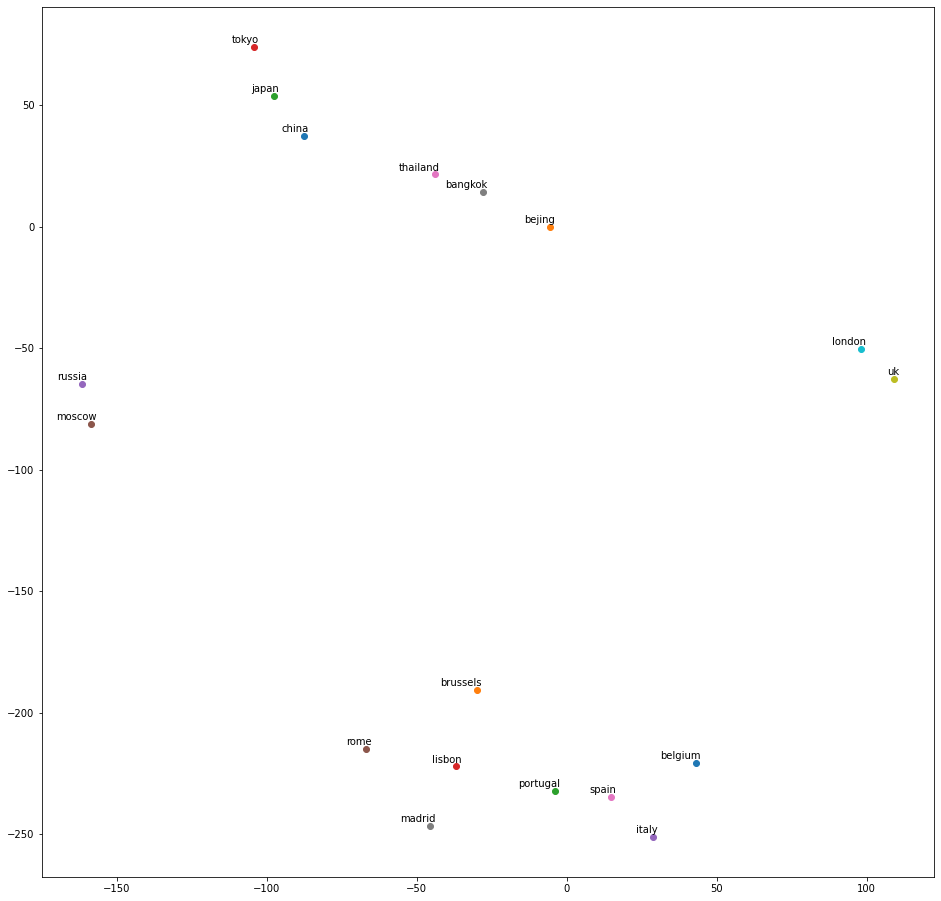

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


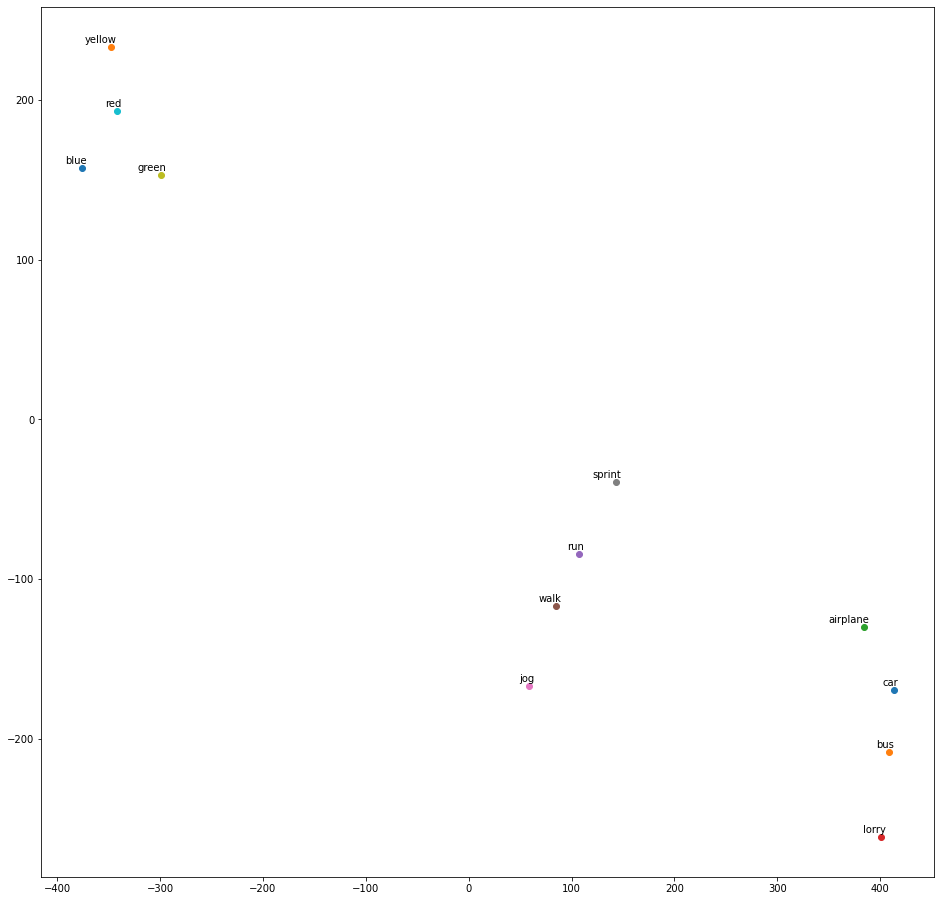

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


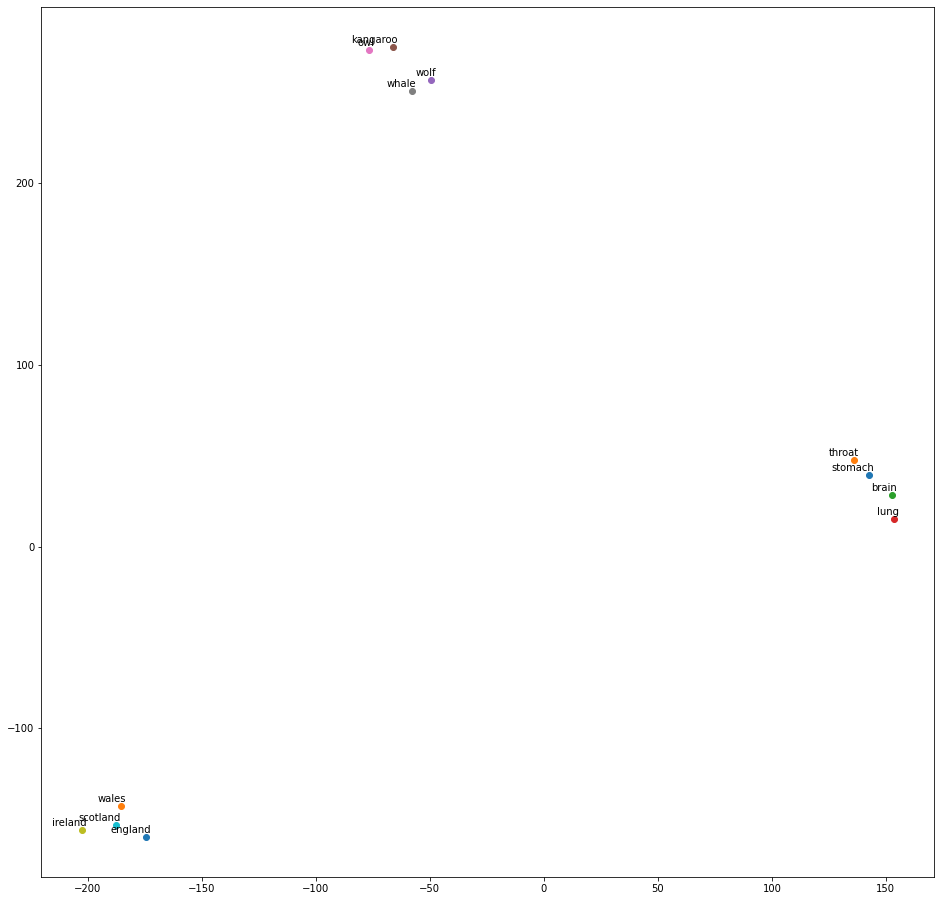

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


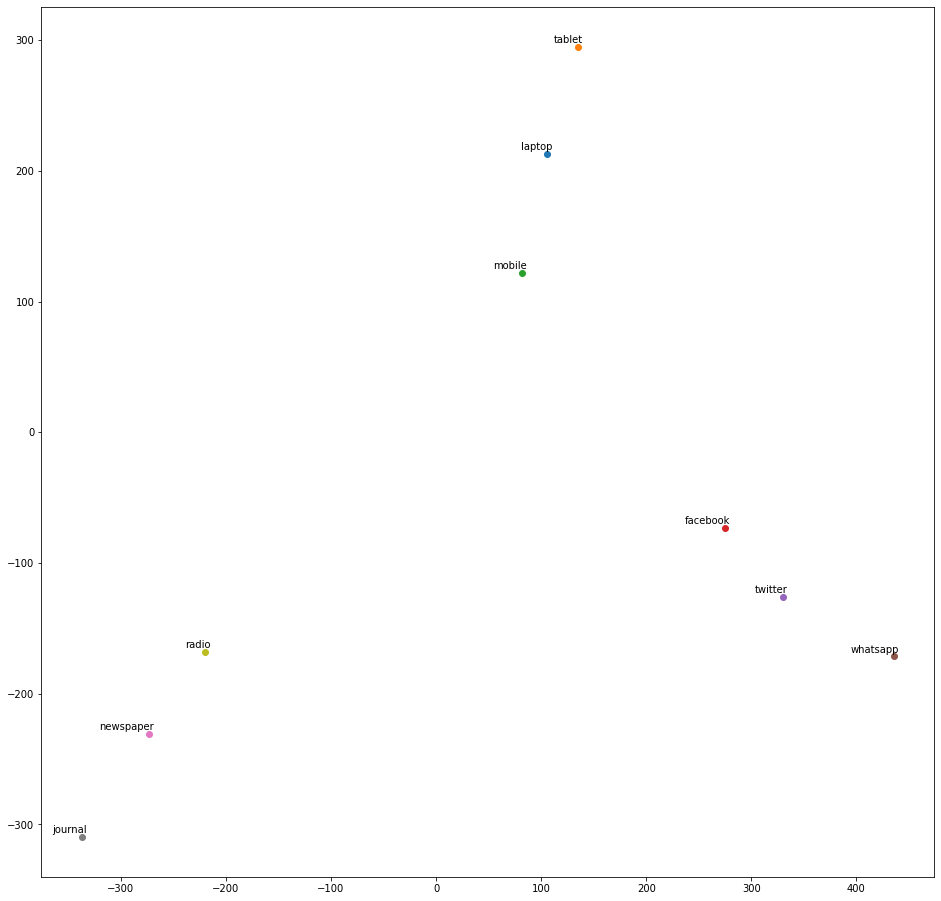

In [9]:
word_list = ('china','bejing', 'japan', 'tokyo', 'italy', 'rome', 'spain', 'madrid', 'uk', 'london'
             ,'belgium', 'brussels', 'portugal', 'lisbon', 'russia','moscow', 'thailand','bangkok')

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)

word_list =('car' ,'bus','airplane', 'lorry','run','walk','jog','sprint', 'green', 'red' ,'blue', 'yellow')

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)

#### START CODE #####

word_list = ('stomach', 'throat', 'brain', 'lung', 'wolf', 'kangaroo', 'owl', 'whale', 'ireland', 'scotland', 'england', 'wales')
new_dict = {k: word_to_vec_map[k] for k in word_list if k in word_to_vec_map}
tsne_plot(new_dict)

word_list = ( 'laptop', 'tablet', 'mobile', 'facebook', 'twitter', 'whatsapp', 'newspaper', 'journal', 'radio')
new_dict = {k: word_to_vec_map[k] for k in word_list if k in word_to_vec_map}
tsne_plot(new_dict)

### END CODE ######


# 2.  Measuring Word Similarity in Vector Space

Next we will generate a way of measuring the similarity of embedding vectors of two given words. We will use the cosine similarity measure since it takes into account the angle of the vector not just the magnitude as it is the angle of the vector that contains most of the semantic meaning. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

where $u.v$ is the dot product (or inner product) of two vectors, $||u||_2$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$. This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

<center><img src="images/cosine_sim.png" width="800px"/></center>

<caption><center> <b>Figure 4</b>: The cosine of the angle between two vectors is a measure of how similar they are</center></caption>

You need to:
- Implement the function `cosine_similarity()` to evaluate similarity between word vectors.

**Note:** The norm of $u$ is defined as $\vert\vert u\vert\vert_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

**Hint** There a many maths functions provided by the numpy library imported in to this notebook as `np` so you can use functions to calculate dot product, square root, L2-norm etc of vectors. e.g. `np.dot(u, v)` 

In [10]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
        
    ### START CODE HERE ###
    #Step 1: Compute the dot product between u and v
    dot = np.dot(u, v)
    #Step 2: Compute the L2 norm of u (≈1 line)
    norm_u = np.linalg.norm(u, ord=2)
    
    #Step 3: Compute the L2 norm of v (≈1 line)
    norm_v = np.linalg.norm(v, ord=2)
    
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = np.divide(dot,(norm_u*norm_v))
    ### END CODE HERE ###
    
    return cosine_similarity

## 2.1 Testing your Similarity Function
Run the code below to test your Similarity function `cosine_similarity()`.

In [11]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.2743924626137942
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174202


**Expected Output**:

<table>
    <tr>
        <td>
            **cosine_similarity(father, mother)** =
        </td>
        <td>
         0.890903844289
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(ball, crocodile)** =
        </td>
        <td>
         0.274392462614
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(france - paris, rome - italy)** =
        </td>
        <td>
         -0.675147930817
        </td>
    </tr>
</table>

After you get the correct expected output, please feel free to modify the inputs and measure the cosine similarity between other pairs of words! Playing around the cosine similarity of other inputs will give you a better sense of how word vectors behave. 

# 2.2 - Word Analogy Task

In the word analogy task, we complete the sentence <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>. An example is <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>. In detail, we are trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner: $e_b - e_a \approx e_d - e_c$. We will measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 

**Exercise**: Complete the code below to be able to perform word analogies!

In [12]:
# complete_analogy

def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lower case
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    ### START CODE HERE ###
    # Get the word embeddings v_a, v_b and v_c (≈1-3 lines)
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    ### END CODE HERE ###
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue
        
        ### START CODE HERE ###
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        ### END CODE HERE ###
        
    return best_word

Run the cell below to test your code, this may take 1-2 minutes.

In [13]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))


print('\nOther Examples :\n')
triads_to_try = [('has', 'have', 'was'), ('she', 'her', 'he'),
                 ('winter', 'cold', 'summer'), ('human', 'mammal', 'bird'), 
                 ('doctor', 'patient', 'engineer'),  ('small', 'smaller', 'big')
                 ]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

    
    

italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> larger

Other Examples :

has -> have :: was -> were
she -> her :: he -> his
winter -> cold :: summer -> cool
human -> mammal :: bird -> seabird
doctor -> patient :: engineer -> productivity
small -> smaller :: big -> competitors


**Expected Output**:

<table>
    <tr>
        <td>
            **italy -> italian** ::
        </td>
        <td>
         spain -> spanish
        </td>
    </tr>
        <tr>
        <td>
            **india -> delhi** ::
        </td>
        <td>
         japan -> tokyo
        </td>
    </tr>
        <tr>
        <td>
            **man -> woman ** ::
        </td>
        <td>
         boy -> girl
        </td>
    </tr>
        <tr>
        <td>
            **small -> smaller ** ::
        </td>
        <td>
         large -> larger
        </td>
    </tr>
</table>

Once you get the correct expected output, please feel free to modify the input cells above to test your own analogies. Try to find some other analogy pairs that do work, but also find some where the algorithm doesn't give the right answer: For example, you can try small->smaller as big->?.  

# 3. Using Counter Factual Testing to Uncover Bias

One way to test for bias in a model is to use counter factual examples. In this section we study counter factual fairness in the model's predictions (for the word analogy tasks above). Specifically factual fairness asks the question: <i>How would the prediction change if the sensitive attribute referenced in the example were different?</i>

If the prediction changes with respect to a sensitive attribute, we consider this an indicator of a potential problem. In contrast to group-based notions of fairness (e.g., demographic parity, equality of odds), which seek to statistically equalize the model’s behavior for entire sensitive groups (we will see this in the final lab), counter factual fairness requires equal model behavior on individual counter factual pairs.

In this case we use a simple for of counter factual test where: we consider perturbations obtained by substituting tokens (words) associated with identity groups. e.g. man with woman, white with Asian, Asian with Black, white with black and so on. i.e. we design a word analogy set of triads where the counter factual tokens are the two of the three words.

In your experiment here you can investigate for any type of bias, for example those from the UK Law Protected Characteristics Equality Act 2010. You must however explore gender (need your discovered list of triads for gender  later). The Protected Characteristics are:

- Age
- Disability
- Gender reassignment
- Marriage and civil partnership
- Pregnancy and maternity
- Race
- Religion and belief
- Sex
- Sexual orientation


Although it is difficult using this type of limited language structure (word analogy) it is possible to uncover examples of bias.  For example try:

- 'white' is to 'boss' what 'black' is to ___
- 'women' is to 'nurse' what 'man' is to ___


**You need to:**

- explore word analogies for evidence of bias (minimum 10)
- capture a list of word analogies that provide evidence of various types of bias.


In [40]:
### START CODE ###
triads_to_try = [('white', 'boss', 'black'), 
                 ('women', 'nurse', 'man'),
                 ('father', 'doctor', 'mother'),
                 ('sister', 'homemaker', 'brother'),
                 ('japan', 'vehicle', 'german'),
                 ('mahela', 'cricket', 'alexander'),
                 ('buddhist', 'japan', 'christian'),
                 ('chine', 'majority', 'ethiopia'),
                 ('girl', 'dancer', 'boy'),
                 ('woman', 'sewing', 'man'),
                 ('expensive', 'england', 'cheaper'),
                 ('female', 'soft', 'male')]
### END CODE ###

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

white -> boss :: black -> hitman
women -> nurse :: man -> anesthetist
father -> doctor :: mother -> patient
sister -> homemaker :: brother -> bricklayer
japan -> vehicle :: german -> truck
mahela -> cricket :: alexander -> hockey
buddhist -> japan :: christian -> germany
chine -> majority :: ethiopia -> minority
girl -> dancer :: boy -> choreographer
woman -> sewing :: man -> woodworking
expensive -> england :: cheaper -> wales
female -> soft :: male -> thin


# 4. Removing Bias from Word Vector Models

In this section, you will examine gender biases (that you may well have found some evidence of using counter factuals above) that can be reflected in a word embedding model, and explore algorithms for reducing the bias.  In addition to learning about the topic of debiasing, this exercise will also help hone your intuition about what word vectors are doing. This section involves a bit of linear algebra, though you can complete it without being expert in linear algebra, by following and implementing the formulas given. 

**your task it to see how the GloVe word embeddings relate to gender:**
  
- You will need  compute a vector $g = e_{woman}-e_{man}$, where $e_{woman}$ represents the word vector corresponding to the word *woman*, and $e_{man}$ corresponds to the word vector corresponding to the word *man*. 

The resulting vector $g$ roughly encodes the concept of "gender". (You might get a more accurate representation if you compute $g_1 = e_{mother}-e_{father}$, $g_2 = e_{girl}-e_{boy}$, etc. and average over them. But just using $e_{woman}-e_{man}$ will give good enough results for now.) 


In [41]:
#### START CODE #####
g = word_to_vec_map['woman'] - word_to_vec_map['man']

#### END CODE ######
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


## 4.1 Word Similarity with Gender, $g$
Now, you will consider the cosine similarity of different words with $g$. Consider what a positive value of similarity means vs a negative cosine similarity. 

**Your task is to:**
- iterate over the list of names and print out the word and word similarity between each word (name) and the gender vector, $g$.
- try a list of your own names

In [42]:
print ('List of names and their similarities with constructed vector:')

# girls and boys names
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

#### START CODE ####
for w in name_list:
    word_vec = word_to_vec_map[w]
    sim = cosine_similarity(word_vec, g)
    print(f'{w} : {sim}')
    
# TODO : Need to revisit
print()
new_list = ['dilshan', 'mahela', 'bhagya', 'kate']

for w in new_list:
    word_vec = word_to_vec_map[w]
    sim = cosine_similarity(word_vec, g)
    print(f'{w} : {sim}')
#### END CODE #####

List of names and their similarities with constructed vector:
john : -0.23163356145973724
marie : 0.315597935396073
sophie : 0.31868789859418784
ronaldo : -0.31244796850329437
priya : 0.17632041839009402
rahul : -0.16915471039231716
danielle : 0.24393299216283895
reza : -0.07930429672199553
katy : 0.2831068659572615
yasmin : 0.2331385776792876

dilshan : -0.4168317873940771
mahela : -0.42206682909587767
bhagya : 0.1467054024647242
kate : 0.2990709043618788


As you can see, female first names tend to have a positive cosine similarity with our constructed vector $g$, while male first names tend to have a negative cosine similarity. This is not suprising, and the result seems acceptable. 

**Your task is to try with some other words:**
- iterate over the provided word list
- second create a new word list of your own to investigate (approx. ten words)

In [43]:
print('Other words and their similarities:\n')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
#### START CODE ####
for w in word_list:
    word_vec_1 = word_to_vec_map[w]
    sim_1 = cosine_similarity(word_vec_1, g)
    print(f'{w} : {sim_1}')
#### END CODE ###

#### START CODE ####
print()
word_list_2 = ['chef', 'driver', 'scientist', 'innovator', 'psychologist', 'cricket', 'rugby', 'swimmer', 'president', 'photography']

for w in word_list_2:
    word_vec_2 = word_to_vec_map[w]
    sim_2 = cosine_similarity(word_vec_2, g)
    print(f'{w} : {sim_2}')
#### END CODE ###

Other words and their similarities:

lipstick : 0.2769191625638267
guns : -0.1888485567898898
science : -0.06082906540929701
arts : 0.008189312385880337
literature : 0.06472504433459932
warrior : -0.20920164641125288
doctor : 0.11895289410935041
tree : -0.07089399175478091
receptionist : 0.3307794175059374
technology : -0.13193732447554302
fashion : 0.03563894625772699
teacher : 0.17920923431825664
engineer : -0.0803928049452407
pilot : 0.0010764498991916937
computer : -0.10330358873850498
singer : 0.1850051813649629

chef : -0.05406355701766897
driver : -0.010681433817247916
scientist : -0.05193035281313462
innovator : -0.20752497909596115
psychologist : 0.21390155741365366
cricket : -0.32051598976757195
rugby : -0.2593529580467866
swimmer : 0.1791471599784979
president : -0.11624635263172776
photography : 0.021159358312508668


Do you notice anything surprising? It is astonishing how these results reflect certain unhealthy gender stereotypes. For example, "computer" is closer to "man" while "literature" is closer to "woman". Ouch! 

We'll see below how to reduce the bias of these vectors, using an algorithm due to [2]. Note that some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related. You will have to treat these two type of words differently when debiasing.

[2] T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama, and A. Kalai, “Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings,” Jul. 2016.[Link to Paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

## 4.2 Neutralize Bias in Word Vectors 

The figure below should help you visualize what neutralizing does. If you're using a 50-dimensional word embedding, the 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which we'll call $g_{\perp}$. In linear algebra, we say that the 49 dimensional $g_{\perp}$ is perpendicular (or "othogonal") to $g$, meaning it is at 90 degrees to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$. 

Even though $g_{\perp}$ is 49 dimensional, given the limitations of what we can draw on a screen, we illustrate it using a 1 dimensional axis below. 

<img src="images/neutral.png" style="width:1000px;"/>
<caption><center> **Figure 3**: The word vector for "receptionist" represented before and after applying the neutralize operation. </center></caption>

**You will need to:**

Implement `neutralize()` to remove the bias of words such as "receptionist" or "scientist". Given an input embedding $e$, you can use the following formulas to compute $e^{debiased}$: 

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$
$$e^{debiased} = e - e^{bias\_component}\tag{3}$$


- Select word vector representation of `word`
- Compute Equation (2)
- Compute Equation (3)

**Hint:** You can make use of some or all of following Numpy functions (search for their usage):

```python
np.dot()
np.square()
np.linalg.norm()
np.sqrt()
```


In [44]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    ### START CODE HERE ###
    #Step1: Select word vector representation of "word". Use . (≈ 1 line)
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula given above. (≈ 1 line)
    e_biascomponent = (np.dot(e, g)/np.dot(np.transpose(g), g))*g
 
    # Neutralize e by substracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection. (≈ 1 line)
    e_debiased = e - e_biascomponent
    ### END CODE HERE ###
    
    return e_debiased

### 4.2.1 Testing your `neutralize` Function

Run the code below to test your neutralize function.

In [45]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

# Need to revisit value
e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))


cosine similarity between receptionist and g, before neutralizing:  0.3307794175059374
cosine similarity between receptionist and g, after neutralizing:  -2.6832242276243644e-17


**Expected Output**: The second result is essentially 0, up to numerical round-off (in the order of $10^{-17}$).


<table>
    <tr>
        <td>
            **cosine similarity between receptionist and g, before neutralizing:** :
        </td>
        <td>
         0.33077941750593737
        </td>
    </tr>
        <tr>
        <td>
            **cosine similarity between receptionist and g, after neutralizing:** :
        </td>
        <td>
         -3.415405087742776e-17
    </tr>
</table>

## 4.3 Equalization Algorithm to De-bias Word Vectors

Next, lets see how debiasing can also be applied to word pairs such as "actress" and "actor." Equalization is applied to pairs of words that you might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralizing to "babysit" we can reduce the gender-stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this. 

The key idea behind equalization is to make sure that a particular pair of words are equidistant from the 49-dimensional $g_\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e_{receptionist}^{debiased}$, or from any other work that has been neutralized. In pictures, this is how equalization works: 

<img src="images/equalize10.png" style="width:800px;height:400px;"\>
<caption><center> **Figure 4**: The word vectors for "actor" and "actress" before and after applying the equalization operation. </center></caption>


The the linear algebra to do this is a bit more complex. (See [2] for more details if you wish). However summarised below are the key steps (equations) to complete the equalization algorithm: 

$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$ 

$$ \mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{5}$$ 

$$\mu_{\perp} = \mu - \mu_{B} \tag{6}$$

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{7}$$ 
$$ e_{w2B} = \frac {e_{w2} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{8}$$


$$e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {||(e_{w1} - \mu_{\perp}) - \mu_B)||_2} \tag{9}$$


$$e_{w2B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w2B}} - \mu_B} {||(e_{w2} - \mu_{\perp}) - \mu_B)||_2} \tag{10}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{11}$$
$$e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{12}$$


**You will need to:**

- Implement the function below. 
- Use the equations above each in turn to get the final equalized version of the pair of words.

Good luck!

In [46]:
from typing import Iterator
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    ### START CODE HERE ###
    # Step 1: Select word vector representation of "word". Use word_to_vec_map. (≈ 2 lines)
    e_w1 = word_to_vec_map[pair[0]]
    e_w2 = word_to_vec_map[pair[1]]
    
    # Step 2: Compute the mean of e_w1 and e_w2 (≈ 1 line)
    mu = (e_w1 + e_w2)/2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis (≈ 2 lines)
    mu_B = (np.dot(mu, bias_axis)/np.dot(np.transpose(bias_axis), bias_axis))*bias_axis
    mu_N = mu - mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B (≈2 lines)
    e_w1B = (np.dot(e_w1, bias_axis)/np.dot(np.transpose(bias_axis), bias_axis))*bias_axis
    e_w2B = (np.dot(e_w2, bias_axis)/np.dot(np.transpose(bias_axis), bias_axis))*bias_axis
    
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above (≈2 lines)
    corrected_e_w1B = np.sqrt(abs(1 - np.dot(np.transpose(mu_N), mu_N)))*((e_w1B - mu_B)/np.linalg.norm(e_w1 - mu_N - mu_B,ord = 2))
    corrected_e_w2B = np.sqrt(abs(1 - np.dot(np.transpose(mu_N), mu_N)))*((e_w2B - mu_B)/np.linalg.norm(e_w2 - mu_N - mu_B,ord = 2))
    
    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections (≈2 lines)
    e1 = corrected_e_w1B + mu_N
    e2 = corrected_e_w2B + mu_N
                                                                 
    ### END CODE HERE ###
    return e1, e2

### 4.3.1 Testing your `equalize` Function

Run the code below to test your equalise function.


In [47]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.7004364289309387
cosine_similarity(e2, gender) =  0.7004364289309389


**Expected Output**:

cosine similarities before equalizing:
<table>
    <tr>
        <td>
            **cosine_similarity(word_to_vec_map["man"], gender)** =
        </td>
        <td>
         -0.117110957653
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(word_to_vec_map["woman"], gender)** =
        </td>
        <td>
         0.356666188463
        </td>
    </tr>
</table>

cosine similarities after equalizing:
<table>
    <tr>
        <td>
            **cosine_similarity(u1, gender)** =
        </td>
        <td>
         -0.18798753406068716
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(u2, gender)** =
        </td>
        <td>
         0.18798753406068716
        </td>
    </tr>
</table>

# 5. Improving Gender Bias and Fairness

These debiasing algorithms are very helpful for reducing bias, but are not perfect and do not eliminate all traces of bias. For example, one weakness of this implementation was that the bias direction $g$ was defined using only the pair of words _woman_ and _man_. As discussed earlier, if $g$ were defined by computing $g_1 = e_{woman} - e_{man}$; $g_2 = e_{mother} - e_{father}$; $g_3 = e_{girl} - e_{boy}$; and so on and averaging over them, you would obtain a better estimate of the "gender" direction in the 50 dimensional word embedding space. 

Using the word combinations that you discovered that pointed toward bais in the model re-run the word analogies on word vectors that have been de-biased using one of the two appropriate methods above.

**You need to:**

- implement the improved 'gender' direction by computing from an average of numerous word pairs $g_{av}$
- de-bias word embeddings using improved $g_{av}$ to be used in your word analogies 
 - Hint iterate over all words in the dictionary `word_to_vec_map` and apply the appropriate form of de-biasing
- re-run your counter factual triads from section 3
- re-run your word similarity with gender from section 4.1
               

In [50]:
### START CODE ###
word_to_vec_map_copy = copy.deepcopy(word_to_vec_map)


#Step 1: create imporved gender vector from averaging several gender pairs
print('.... Calculating average gender vector ....')
g_1 = word_to_vec_map_copy['girl'] - word_to_vec_map_copy['boy']
g_2 = word_to_vec_map_copy['mother'] - word_to_vec_map_copy['father']
g_3 = word_to_vec_map_copy['woman'] - word_to_vec_map_copy['man']
g_av = (g_1 + g_2 + g_3)/3
print(f'Average gender vector(g_av) : \n{g_av}')

#Step 2: debias word embeddings
print('\n.... Debiasing word embedding using neutralisation and equalisation ....')

# Define gender specific words
gender_specific_words = ['he',' his',' her',' she',' him',' man',' women',' men',' woman',' spokesman',' wife',' himself',' son',' mother',' father',
'chairman',' daughter',' husband',' guy',' girls',' girl',' boy',' boys',' brother',' spokeswoman',' female',' sister',' male',
'herself',' brothers',' dad',' actress',' mom',' sons',' girlfriend',' daughters',' lady',' boyfriend',' sisters',' mothers',
'king',' businessman',' grandmother',' grandfather',' deer',' ladies',' uncle',' males',' congressman',' grandson',
'bull',' queen',' businessmen',' wives',' widow',' nephew',' bride',' females',' aunt',' prostate cancer',' lesbian',
'chairwoman',' fathers',' moms',' maiden',' granddaughter',' younger brother',' lads',' lion',' gentleman',' fraternity',
'bachelor',' niece',' bulls',' husbands',' prince',' colt',' salesman',' hers',' dude',' beard',' filly',' princess',' lesbians',
'councilman',' actresses',' gentlemen',' stepfather',' monks',' ex girlfriend',' lad',' sperm',' testosterone',' nephews',
'maid',' daddy',' mare',' fiance',' fiancee',' kings',' dads',' waitress',' maternal',' heroine',' nieces',' girlfriends',' sir',
'stud',' mistress',' lions',' estranged wife',' womb',' grandma',' maternity',' estrogen',' ex boyfriend',' widows',
'gelding',' diva',' teenage girls',' nuns',' czar',' ovarian cancer',' countrymen',' teenage girl',' penis',' bloke',' nun',
'brides',' housewife',' spokesmen',' suitors',' menopause',' monastery',' motherhood',' brethren',' stepmother',
'prostate',' hostess',' twin brother',' schoolboy',' brotherhood',' fillies',' stepson',' congresswoman',' uncles',' witch',
'monk',' viagra',' paternity',' suitor',' sorority',' macho',' businesswoman',' eldest son',' gal',' statesman',' schoolgirl',
'fathered',' goddess',' hubby',' stepdaughter',' blokes',' dudes',' strongman',' uterus',' grandsons',' studs',' mama',
'godfather',' hens',' hen',' mommy',' estranged husband',' elder brother',' boyhood',' baritone',' grandmothers',
'grandpa',' boyfriends',' feminism',' countryman',' stallion',' heiress',' queens',' witches',' aunts',' semen',' fella',
'granddaughters',' chap',' widower',' salesmen',' convent',' vagina',' beau',' beards',' handyman',' twin sister',
'maids',' gals',' housewives',' horsemen',' obstetrics',' fatherhood',' councilwoman',' princes',' matriarch',' colts',
'ma',' fraternities',' pa',' fellas',' councilmen',' dowry',' barbershop',' fraternal',' ballerina']

# Define gender specific pairs
gender_equlize_pairs = [('woman', 'man'),
                        ('she', 'he'),
                        ('her', 'his'),
                        ('mother', 'father'),
                        ('wife', 'husband'),
                        ('daughter', 'son'),
                        ('girl', 'boy'),
                        ('female', 'male'),
                        ('sister', 'brother'),
                        ('spokeswoman', 'spokesman'),
                        ('herself', 'himself'),
                        ('mom', 'dad'),
                        ('actress','actor'),
                        ('girlfriend', 'boyfriend'),
                        ('queen', 'king'),
                        ('businesswoman', 'businessman')]

# Gender neutral words >> neutralized
for word in word_to_vec_map_copy:
  if(word not in gender_specific_words):
    neutralized_word_vector = neutralize(word, g_av, word_to_vec_map_copy)
    word_to_vec_map_copy[word] = neutralized_word_vector

# Gender specific words >> equalized
for pair in gender_equlize_pairs:
  word_1 = pair[0]
  word_2 = pair[1]
  word_v_1, word_v_2 = equalize((word_1, word_2), g_av, word_to_vec_map_copy)
  word_to_vec_map_copy[word_1] = word_v_1
  word_to_vec_map_copy[word_2] = word_v_2


#Step 3: re-run word anlogies (counter factuals).
print('\n.... Executing counter factuals after debiasing ....')
triads_to_try = [('white', 'boss', 'black'), 
                 ('women', 'nurse', 'man'),
                 ('father', 'doctor', 'mother'),
                 ('sister', 'homemaker', 'brother'),
                 ('girl', 'dancer', 'boy'),
                 ('woman', 'sewing', 'man'),
                 ('japan', 'vehicle', 'german'),
                 ('mahela', 'cricket', 'alexander'),
                 ('buddhist', 'japan', 'christian'),
                 ('chine', 'majority', 'ethiopia'),
                 ('expensive', 'england', 'cheaper')]

for triad in triads_to_try:
  print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map_copy)))

# Step 4: re-run word-gender simlarities
print('\n.... Executing word-gender similarities after debias ....')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    word_vec_1 = word_to_vec_map_copy[w]
    sim_1 = cosine_similarity(word_vec_1, g_av)
    print(f'{w} : {sim_1}')

### END CODE ###

.... Calculating average gender vector ....
Average gender vector(g_av) : 
[ 0.07656667  0.34967667 -0.40057667 -0.03130333  0.0088      0.72586333
  0.10256     0.14906333  0.4780662  -0.22850987  0.05957667 -0.68663
  0.62210033  0.10395     0.17747667  0.09556867 -0.49258333 -0.17066233
  0.46930033  0.02196333  0.28145667  0.50513333  0.17144733  0.40154767
  0.24039333  0.1646     -0.17984667  0.24042667  0.05689333 -0.31423
 -0.10933333  0.26355967  0.06100667 -0.01156405 -0.12236333 -0.188245
 -0.13215057 -0.068186    0.05624667 -0.29555567 -0.09669533 -0.29559667
  0.62465867 -0.40130167  0.03330667 -0.24831667  0.26381667 -0.28738333
  0.03020433  0.054106  ]

.... Debiasing word embedding using neutralisation and equalisation ....

.... Executing counter factuals after debiasing ....
white -> boss :: black -> hitman
women -> nurse :: man -> anesthetist
father -> doctor :: mother -> polygraph
sister -> homemaker :: brother -> schoolteacher
girl -> dancer :: boy -> choreographe

<h1> 6. Critical Analysis, Reflection & Discussion</h1>

- What observations have you made when using for counter factuals for bias/fairness detection, specifically
    - its ability to detect potential bias
    - its ability to verify removal of bias
- What considerations might you make to the design of the improved Gender bias Vector to maximise fairness in the debiasing algorithm.
     - How do you think we should design the list of word pairs that generate $g_{av}$?
- What evidence have you found that this approach to de-biasing word vectors is effective?
- What are the limitations to this approach to de-biasing and why?
    - Can you think of approaches and actions that can help mitigate any limitations
- Think about and suggest an approach on how you might de-bias a non-linear model space.

(1)
Counter factual examples can be used to identify different types of biases and words influenced from those types(gender, religion, etc) in a given word emdebbing. It depends on the source which was used to train the word embedding(newspapare, journal, article).

Sister>>Homemaker :: Brother>>Bricklayer (Detect gender bias)

Buddhist >> japan :: Christian >> Germany (Detect religion bias)

Same counter factual examples can be used to validate the accuracy of debiased algorithm.

Sister>>Homemaker :: Brother>>School Teacher (Validated gender bias)

But, counter factualexamples relevant to the sterio type removed would be shown debiased result and others may remain without change. In this case, counter factual examples related to religion has not been changed by the gender debiased algorithm.

Buddhist >> Japan :: Christian -> Germany


(2)
A subset of gender specific words in w2vNEWS was used to define a more fair gender vector to optimize this debiasing algorithm. we can use multiple sources to retrive more number of gender specific pairs to calculate average gender vector.

(3) 
Since it uses neutralisation and equalisation steps, it removes gender component from gender neutral words as well as pertains equality between gender specific words(every nuetralised word is located equi-distance from gender specific pairs).In addition, this is more robust and same algorithm can be used to debias other types of biases with some specific modifications.On the other hand, it has less computational complexity because it is a linear method.

(4) 
In this algorithm, gender specific words are pre-defined and there is no dynamic way to identify its correct category(gender specific or neutra).In addition to that there there are some words that have multiple meanings and one or few of them are gender specific while others are gender neutral.

(5) 
A kernal(mask) can be defined(trained) to remove bias from non linear model space.




Reference : 

Bolukbasi, T., Chang, K. W., Zou, J. Y., Saligrama, V., & Kalai, A. T. (2016). Man is to computer programmer as woman is to homemaker? debiasing word embeddings. Advances in neural information processing systems, 29.


